# Dados Matriciais

Estes dados podem ser representados como arrays de N dimensões.

Cada dimensão representará um aspecto (característica) do ambiente

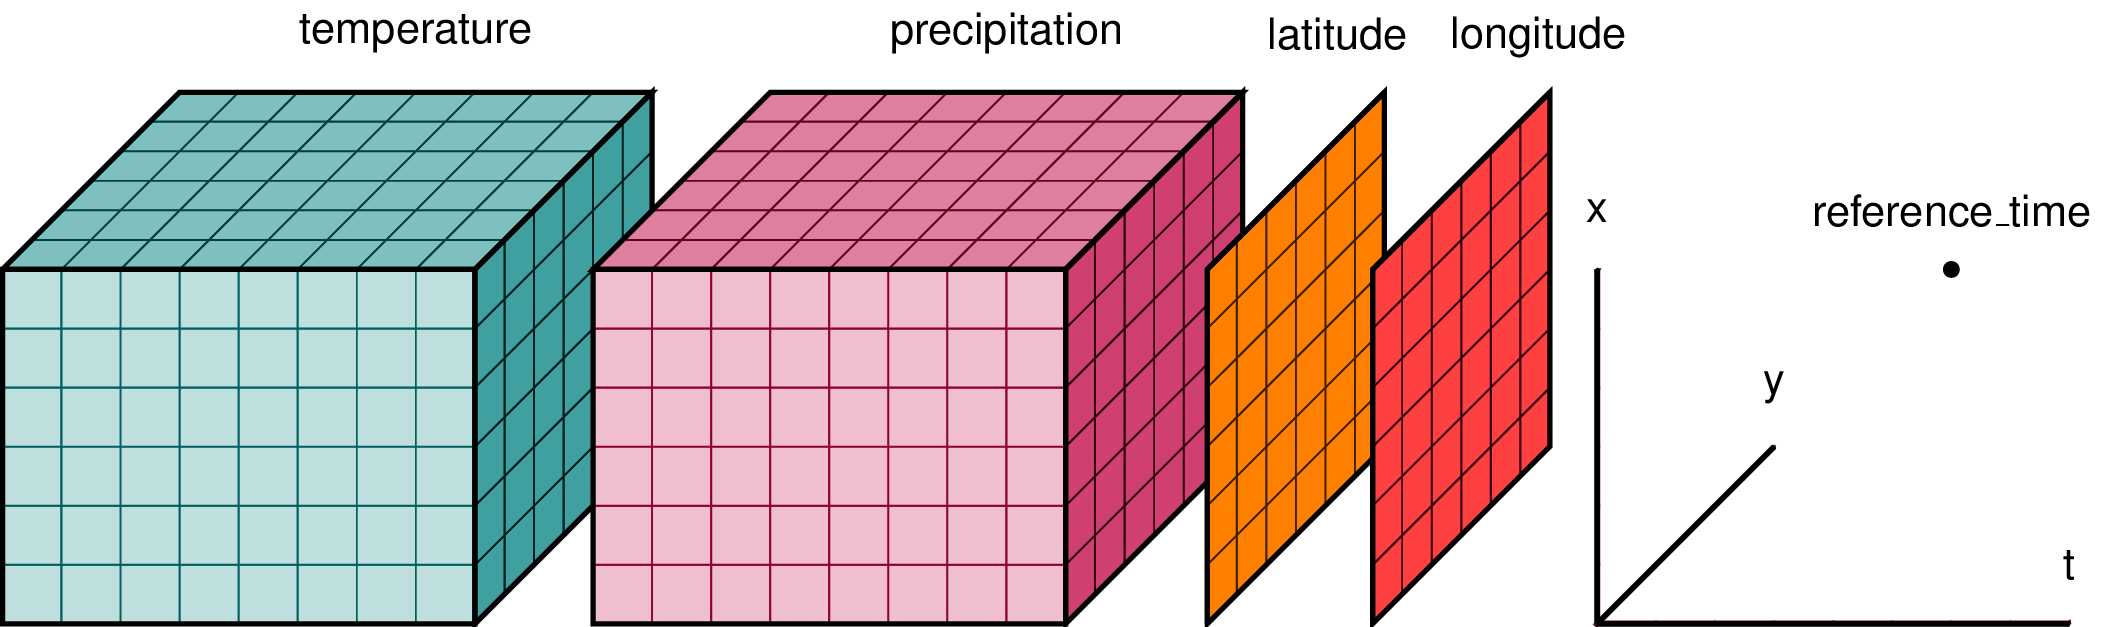

## Aquisição

A aquisição pode ser via:

*   sensoriamento remoto
*   Modelagem Numérica (e.g., MNT)
*   Interpolação de Amostragens de campo



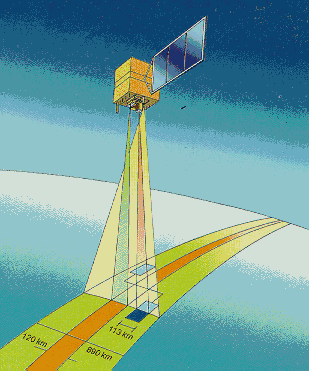

# Exemplo de Caso: dados CHIRPS


## Sumário


1.   Downloading CHIRPS DATA
2.   Operações Temporais de agregação

## Instalando algumas bibliotecas

In [1]:
!pip install climate-indices

!pip install xarray cartopy geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 1.4 MB/s eta 0:00:00


In [3]:
import os, ftplib, shutil, operator
import numpy as np
import zipfile
import pandas as pd
from functools import reduce
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import folium
from climate_indices import indices, compute

## Definição de classe para download dos dados CHIRPS

In [4]:
class CHIRPSFTP():
  def __init__(self):

    self.ftp = ftplib.FTP('data.chc.ucsb.edu', user='anonymous')

    self.ftp.cwd(self.filesRemoteDirectory)

    self.__filesInDir = pd.Series(self.ftp.nlst())

  @property
  def filesInDir(self):
    self.__filesInDir = pd.Series(self.ftp.nlst())
    return self.__filesInDir

  @property
  def filesRemoteDirectory(self):
    return "pub/org/chg/products/CHIRP/daily/netcdf"

  def downloadFilesFromDateRange(self, startyear: int, endyear: int):
    filesInDir = self.filesInDir
    for year in range(startyear, endyear + 1):
      filename = filesInDir[filesInDir.str.contains(str(year))].values[0]
      print("filename: ", filename)
      self.downloadfile(filename)

  def downloadfile(self, filename, local=None):
    if local is None:
      local = os.getcwd()
    targetFilename = os.path.join(local , filename)

    if os.path.exists(targetFilename):
      pass

    else:
      with open(os.path.join(local , filename), 'wb') as file:

        self.ftp.retrbinary('RETR ' + filename, file.write)
        print(filename, " was downloaded")

In [5]:
downloader = CHIRPSFTP()

In [6]:
downloader.downloadFilesFromDateRange(startyear=1981, endyear = 1983)

filename:  chirp.1981.days_p05.nc
chirp.1981.days_p05.nc  was downloaded
filename:  chirp.1982.days_p05.nc
chirp.1982.days_p05.nc  was downloaded
filename:  chirp.1983.days_p05.nc
chirp.1983.days_p05.nc  was downloaded


## Leitura do Dataset

In [7]:
ds = xr.open_mfdataset("chirp*.nc", engine="h5netcdf")

ds = ds.assign_coords(longitude=((ds.longitude + 180) % 360 - 180))
ds = ds.assign_coords(latitude=((ds.latitude + 90) % 180 - 90))

ds

<xarray.Dataset>
Dimensions:    (latitude: 2000, longitude: 7200, time: 1095)
Coordinates:
  * latitude   (latitude) float32 -49.97 -49.92 -49.88 ... 49.88 49.92 49.98
  * longitude  (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1983-12-31
Data variables:
    precip     (time, latitude, longitude) float32 dask.array<chunksize=(365, 2000, 7200), meta=np.ndarray>
Attributes: (12/13)
    Conventions:       CF-1.6
    title:             CHIRP  Version 1.0
    history:           created by Climate Hazards Group
    version:           Version 1.0
    date_created:      2017-10-24
    creator_name:      Pete Peterson
    ...                ...
    institution:       Climate Hazards Group.  University of California at Sa...
    documentation:     http://pubs.usgs.gov/ds/832/
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html

## Operações de Filtro Espacial

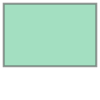

In [8]:
# Let's select a subregion of the Globe (Brazil Country for instance)

## Defining bbox
# (Check spatial ref here: http://bboxfinder.com/)

SPEdges = {'latmin':   -25.032658,
              'longmin':  -53.068360,
              'latmax':   -19.584462,
              'longmax':  -45.004395}

SPBbox = box(SPEdges["longmin"],
                 SPEdges["latmin"],
                 SPEdges["longmax"],
                 SPEdges["latmax"])

SPBbox


## OpenStreetMap

In [9]:



gdf = gpd.GeoSeries([SPBbox], crs="EPSG:4326")
lat = gdf.centroid.y.values[0]
lon = gdf.centroid.x.values[0]

print("lat: ", lat, "lon: ", lon)

map = folium.Map(location = [lat, lon],
                 tiles='OpenStreetMap',
                 zoom_start=2,
                 control_scale=True)


geo_j = gdf.to_json()
geo_j = folium.GeoJson(data=geo_j,
                        style_function=lambda x: {'fillColor': 'orange'})
geo_j.add_to(map)

folium.Marker(location=[lat, lon],
              popup='Name: {}'.format("São Paulo (city)")).add_to(map)

map

lat:  -22.30856 lon:  -49.03637750000001


In [10]:

## Slicing data

def splitNetcdfGivenBbox(ds:xr.Dataset, bbox: box) -> xr.Dataset:
  xmin, ymin, xmax, ymax = bbox.bounds

  Spatially_Sliced = ds.sel(latitude=slice(ymin, ymax),
                            longitude=slice(xmin, xmax )
                           )

  return Spatially_Sliced


splitted = splitNetcdfGivenBbox(ds, SPBbox)

splitted = splitted.chunk({'latitude': 10, 'longitude': 10, 'time': 10})

splitted


<xarray.Dataset>
Dimensions:    (latitude: 109, longitude: 161, time: 1095)
Coordinates:
  * latitude   (latitude) float32 -25.03 -24.97 -24.93 ... -19.72 -19.68 -19.62
  * longitude  (longitude) float32 -53.03 -52.98 -52.93 ... -45.12 -45.07 -45.03
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1983-12-31
Data variables:
    precip     (time, latitude, longitude) float32 dask.array<chunksize=(10, 10, 10), meta=np.ndarray>
Attributes: (12/13)
    Conventions:       CF-1.6
    title:             CHIRP  Version 1.0
    history:           created by Climate Hazards Group
    version:           Version 1.0
    date_created:      2017-10-24
    creator_name:      Pete Peterson
    ...                ...
    institution:       Climate Hazards Group.  University of California at Sa...
    documentation:     http://pubs.usgs.gov/ds/832/
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html

## Série Temporal da precipitação de São Paulo


In [11]:
spLon = -46.635197
spLat = -23.618237
SP_Precip_Time_series = splitted.sel({"longitude": spLon,
                                      "latitude":  spLat},
                                     method='nearest'
                                   )

SP_Precip_Time_series

<xarray.Dataset>
Dimensions:    (time: 1095)
Coordinates:
    latitude   float32 -23.62
    longitude  float32 -46.62
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1983-12-31
Data variables:
    precip     (time) float32 dask.array<chunksize=(10,), meta=np.ndarray>
Attributes: (12/13)
    Conventions:       CF-1.6
    title:             CHIRP  Version 1.0
    history:           created by Climate Hazards Group
    version:           Version 1.0
    date_created:      2017-10-24
    creator_name:      Pete Peterson
    ...                ...
    institution:       Climate Hazards Group.  University of California at Sa...
    documentation:     http://pubs.usgs.gov/ds/832/
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html

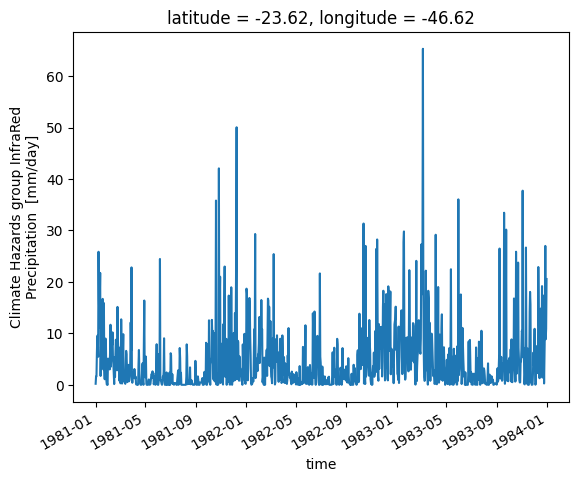

In [12]:
SP_Precip_Time_series["precip"].plot()

Dims order ('latitude', 'longitude')
<class 'matplotlib.collections.QuadMesh'>


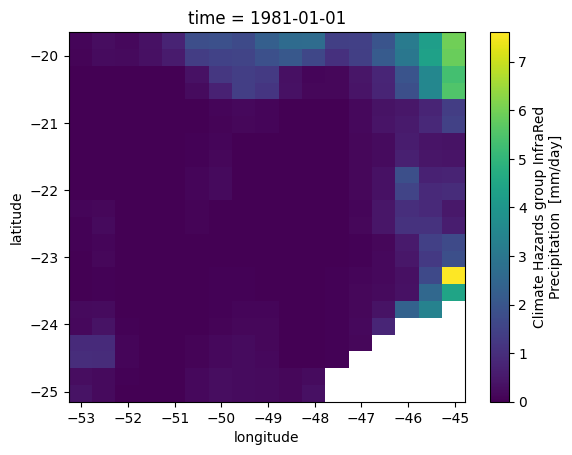

In [13]:
daT0 = splitted["precip"].isel({"time":0})

print("Dims order",daT0.dims)
latitudeWindowsSize = 5
longitudeWindowsSize = 10

ax = (
        daT0[::latitudeWindowsSize,
            ::longitudeWindowsSize]
        .plot(cmap="viridis",
              x="longitude",
              y="latitude")
      )

print(type(ax))

## Precipitação média de São Paulo

In [14]:
MonthlyMeans = splitted.groupby("time.month").mean()
MonthlyMeans

<xarray.Dataset>
Dimensions:    (latitude: 109, longitude: 161, month: 12)
Coordinates:
  * latitude   (latitude) float32 -25.03 -24.97 -24.93 ... -19.72 -19.68 -19.62
  * longitude  (longitude) float32 -53.03 -52.98 -52.93 ... -45.12 -45.07 -45.03
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip     (month, latitude, longitude) float32 dask.array<chunksize=(1, 10, 10), meta=np.ndarray>
Attributes: (12/13)
    Conventions:       CF-1.6
    title:             CHIRP  Version 1.0
    history:           created by Climate Hazards Group
    version:           Version 1.0
    date_created:      2017-10-24
    creator_name:      Pete Peterson
    ...                ...
    institution:       Climate Hazards Group.  University of California at Sa...
    documentation:     http://pubs.usgs.gov/ds/832/
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html

In [27]:
# Seleção temporal mensal dos dados

SlicedMonthlyMeans = MonthlyMeans.isel(month=slice(None, 6)
                                                )
SlicedMonthlyMeans


<xarray.Dataset>
Dimensions:    (latitude: 109, longitude: 161, month: 6)
Coordinates:
  * latitude   (latitude) float32 -25.03 -24.97 -24.93 ... -19.72 -19.68 -19.62
  * longitude  (longitude) float32 -53.03 -52.98 -52.93 ... -45.12 -45.07 -45.03
  * month      (month) int64 1 2 3 4 5 6
Data variables:
    precip     (month, latitude, longitude) float32 dask.array<chunksize=(1, 10, 10), meta=np.ndarray>
Attributes: (12/13)
    Conventions:       CF-1.6
    title:             CHIRP  Version 1.0
    history:           created by Climate Hazards Group
    version:           Version 1.0
    date_created:      2017-10-24
    creator_name:      Pete Peterson
    ...                ...
    institution:       Climate Hazards Group.  University of California at Sa...
    documentation:     http://pubs.usgs.gov/ds/832/
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html

## Operações de Agregação temporal

In [16]:
def monthlyMean(ds: xr.Dataset) -> xr.Dataset:

  return ds.groupby("time.month").mean(keep_attrs=True)

AnnualMonthlyMeans = splitted.groupby("time.year").apply(monthlyMean)

AnnualMonthlyMeans

<xarray.Dataset>
Dimensions:    (latitude: 109, longitude: 161, year: 3, month: 12)
Coordinates:
  * latitude   (latitude) float32 -25.03 -24.97 -24.93 ... -19.72 -19.68 -19.62
  * longitude  (longitude) float32 -53.03 -52.98 -52.93 ... -45.12 -45.07 -45.03
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * year       (year) int64 1981 1982 1983
Data variables:
    precip     (year, month, latitude, longitude) float32 dask.array<chunksize=(1, 1, 10, 10), meta=np.ndarray>
Attributes: (12/13)
    Conventions:       CF-1.6
    title:             CHIRP  Version 1.0
    history:           created by Climate Hazards Group
    version:           Version 1.0
    date_created:      2017-10-24
    creator_name:      Pete Peterson
    ...                ...
    institution:       Climate Hazards Group.  University of California at Sa...
    documentation:     http://pubs.usgs.gov/ds/832/
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html

## Visualização das precipitações médias por mês

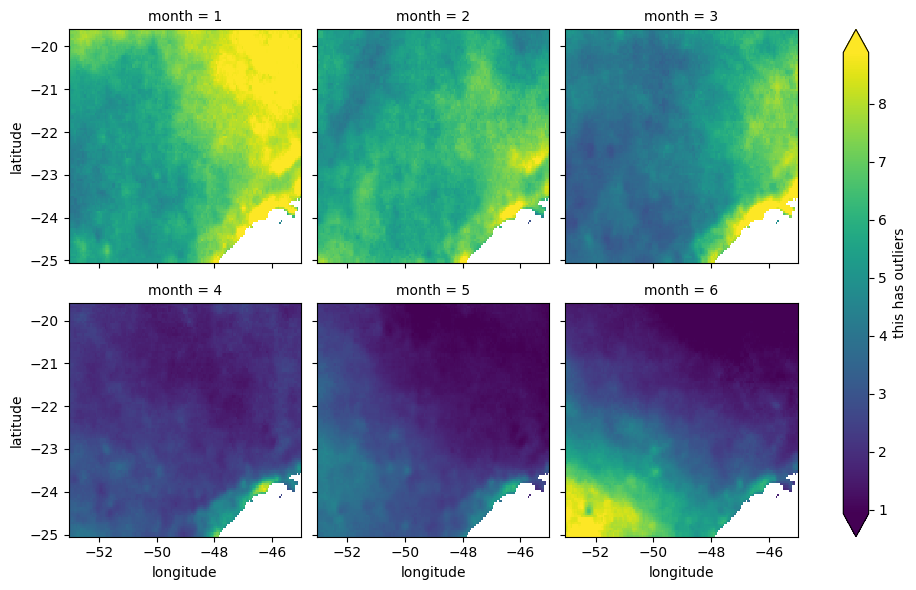

In [17]:
SlicedMonthlyMeans["precip"].plot(x="longitude", y="latitude",
                                  col="month", col_wrap=3,
                                  robust=True,
                                  cmap="viridis",
                                  cbar_kwargs={"label": "this has outliers"}
)


plt.show()

# let's compare the annual variation of Precipitation over São Paulo Centroid between the different years

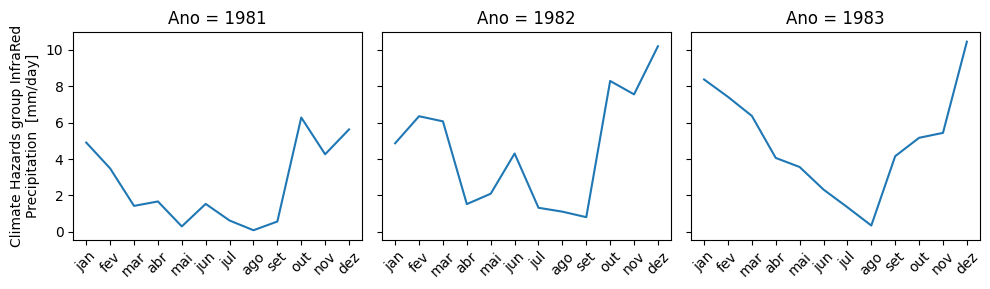

In [45]:
SPCentroidlat = gdf.centroid.y.values[0]
SPCentroidlon = gdf.centroid.x.values[0]


data = (AnnualMonthlyMeans["precip"]
                .sel(longitude=SPCentroidlon,
                      latitude=SPCentroidlat,
                     method='nearest'))


g_simple_line = data.plot(col="year",
                          col_wrap=3,
                          xticks = np.arange(1,13)
                          )

# convertendo os xticks numéricos em labels
for ax in g_simple_line.axs.ravel():
  ax.set_xticklabels(["jan", "fev", 'mar', "abr", "mai", "jun", "jul", "ago", "set", "out", 'nov', "dez"], rotation=45)
  ax.set_title(ax.get_title().replace("year","Ano"))
  ax.set_xlabel("")

plt.show()


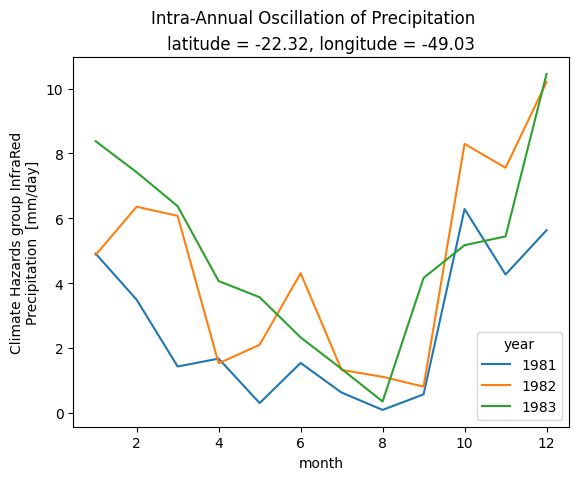

In [19]:

# Plotting multi lines (one line for each Year)
fig, ax = plt.subplots()
MultiLinePlot = (AnnualMonthlyMeans["precip"]
                .sel(longitude=SPCentroidlon,
                      latitude=SPCentroidlat,
                     method='nearest')
                .plot.line(ax=ax,
                           x='month')
)

fig.suptitle("Intra-Annual Oscillation of Precipitation")
plt.show()


In [20]:
def saveFile(ds:xr.Dataset, filename:str) -> None:
  print("Saving file")
  ds.to_netcdf(filename)
  print("\t File saved")

def readFile(filename:str) -> xr.Dataset:
  print("Reading File")
  return xr.open_dataset(filename)

def allInOne(ds:xr.Dataset, filename:str) -> xr.Dataset:

  saveFile(ds, filename)
  return readFile(filename)

splitted = allInOne(splitted, "sliced.nc")

Saving file
	 File saved
Reading File


In [21]:
splitted

<xarray.Dataset>
Dimensions:    (time: 1095, latitude: 109, longitude: 161)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1983-12-31
  * longitude  (longitude) float32 -53.03 -52.98 -52.93 ... -45.12 -45.07 -45.03
  * latitude   (latitude) float32 -25.03 -24.97 -24.93 ... -19.72 -19.68 -19.62
Data variables:
    precip     (time, latitude, longitude) float32 ...
Attributes: (12/13)
    Conventions:       CF-1.6
    title:             CHIRP  Version 1.0
    history:           created by Climate Hazards Group
    version:           Version 1.0
    date_created:      2017-10-24
    creator_name:      Pete Peterson
    ...                ...
    institution:       Climate Hazards Group.  University of California at Sa...
    documentation:     http://pubs.usgs.gov/ds/832/
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html

## Evaluating some environmental indexes

Standardized Precipitation Index [(SPI)](https://climatedataguide.ucar.edu/climate-data/standardized-precipitation-index-spi):

it is a widely used index to characterize meteorological drought on a range of timescales. On short timescales, the SPI is closely related to soil moisture, while at longer timescales, the SPI can be related to groundwater and reservoir storage. The SPI can be compared across regions with markedly different climates. It quantifies observed precipitation as a standardized departure from a selected probability distribution function that models the raw precipitation data. T

In [22]:
# skip over this grid cell if all NaN values
da = splitted["precip"]
initial_year = int(da['time'][0].dt.year)

monthly_vals_shape = (1, 1, 12)
alphas = np.full(shape=monthly_vals_shape, fill_value=np.NaN)
betas = np.full(shape=monthly_vals_shape, fill_value=np.NaN)
scale_months = 3
gamma_params = {"alphas": alphas, "betas": betas}

def evaluateSPI(da:np.ndarray) -> np.ndarray:
  nanEval = np.isnan(da)
  if all(nanEval):
    return da
  else:
    pass
  # compute SPI/gamma for the 3-month scale
  SPI = indices.spi(
          da,
          scale=scale_months,
          distribution=indices.Distribution.gamma,
          data_start_year=initial_year,
          calibration_year_initial=1900,
          calibration_year_final=2000,
          periodicity=compute.Periodicity.monthly,
          )

  return SPI

In [23]:
spiPrecip = xr.apply_ufunc(evaluateSPI,
                           da.chunk({"time":-1}),
                           input_core_dims=[["time"]],
                           output_core_dims= [["time"]],
                           exclude_dims = set(),
                           dask="parallelized",
                           vectorize =True,
                           keep_attrs=True,
                           output_dtypes=[float],
                           dask_gufunc_kwargs= {"allow_rechunk":True}
                      )


spiPrecip

<xarray.DataArray 'precip' (latitude: 109, longitude: 161, time: 1095)>
dask.array<transpose, shape=(109, 161, 1095), dtype=float64, chunksize=(109, 161, 1095), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1983-12-31
  * longitude  (longitude) float32 -53.03 -52.98 -52.93 ... -45.12 -45.07 -45.03
  * latitude   (latitude) float32 -25.03 -24.97 -24.93 ... -19.72 -19.68 -19.62
Attributes:
    units:               mm/day
    standard_name:       convective precipitation rate
    long_name:           Climate Hazards group InfraRed Precipitation 
    time_step:           day
    geostatial_lat_min:  -50.0
    geostatial_lat_max:  50.0
    geostatial_lon_min:  -180.0
    geostatial_lon_max:  180.0

In [24]:
help(xr.apply_ufunc)

Help on function apply_ufunc in module xarray.core.computation:

apply_ufunc(func: 'Callable', *args: 'Any', input_core_dims: 'Sequence[Sequence] | None' = None, output_core_dims: 'Sequence[Sequence] | None' = ((),), exclude_dims: 'Set' = frozenset(), vectorize: 'bool' = False, join: 'JoinOptions' = 'exact', dataset_join: 'str' = 'exact', dataset_fill_value: 'object' = <no-fill-value>, keep_attrs: 'bool | str | None' = None, kwargs: 'Mapping | None' = None, dask: 'str' = 'forbidden', output_dtypes: 'Sequence | None' = None, output_sizes: 'Mapping[Any, int] | None' = None, meta: 'Any' = None, dask_gufunc_kwargs: 'dict[str, Any] | None' = None) -> 'Any'
    Apply a vectorized function for unlabeled arrays on xarray objects.
    
    The function will be mapped over the data variable(s) of the input
    arguments using xarray's standard rules for labeled computation, including
    alignment, broadcasting, looping over GroupBy/Dataset variables, and
    merging of coordinates.
    
    Par

In [25]:
MonthlyMax = spiPrecip.groupby("time.month").max()

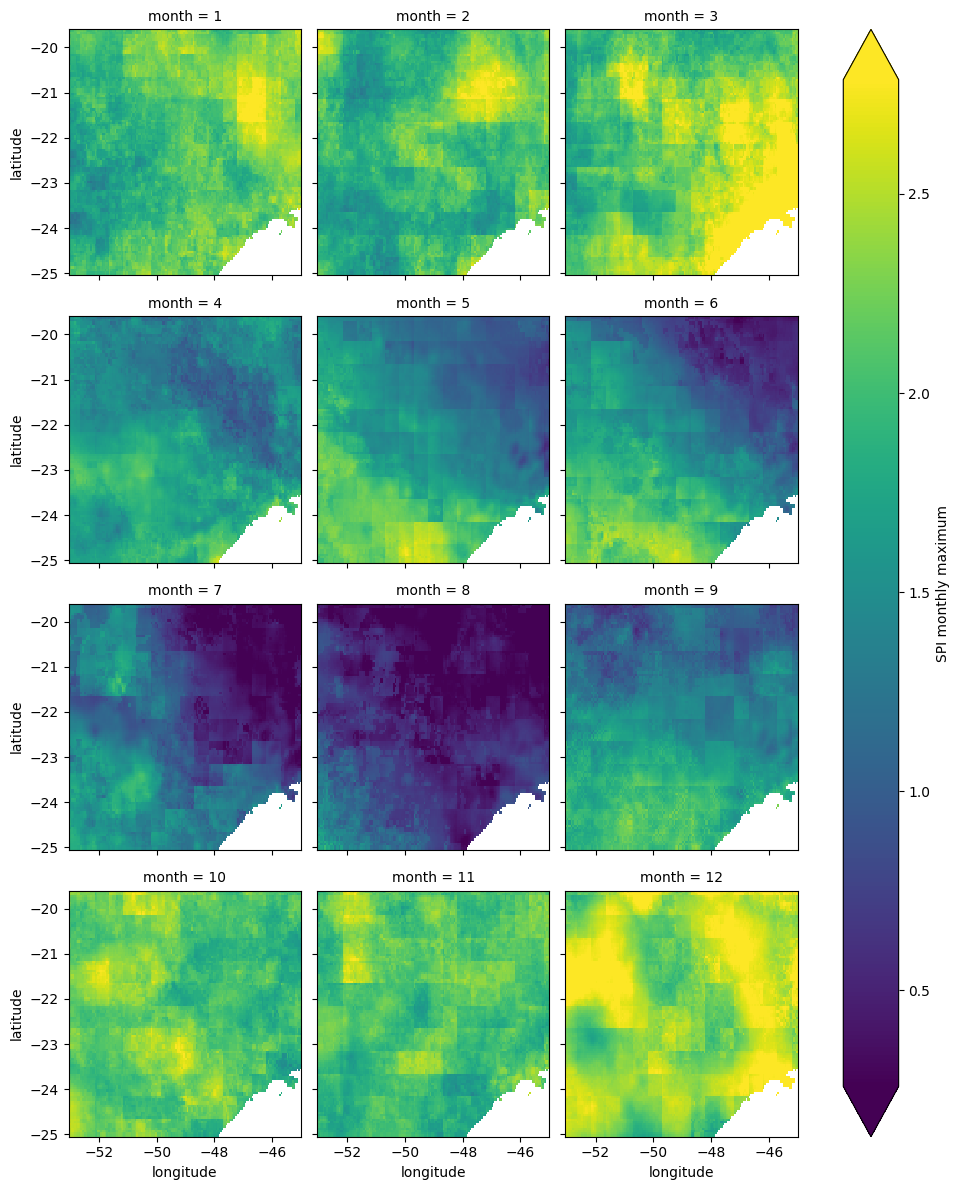

In [26]:
MonthlyMax.plot(x="longitude",
                y="latitude",
                col="month",
                col_wrap=3,
                robust=True,
                cmap="viridis",
                cbar_kwargs={"label": "SPI monthly maximum"}
                )

plt.show()